In [1]:
import requests
import os
import random
import time
import json

import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm

from bs4 import BeautifulSoup

# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException

# import chromedriver_autoinstaller
# import chromedriver_binary

In [2]:
products_df = pd.read_csv("extendedWalmartData_with_brand_updated.csv")

In [3]:
products_df.head()

,Unnamed: 0,name,price,stars,reviews,sponsored,rank,is_walmart_brand
0,0,"Fresh Envy Apples, Each",$1.48,3.3,452.0,True,1,True
1,1,"Fresh Gala Apples, 3 lb Bag",$3.46,NaN,NaN,False,2,True
2,2,"Fresh Gala Apple, Each",$0.64,NaN,NaN,False,3,True
3,3,"Fresh Honeycrisp Apples, 3 lb Bag",$5.46,NaN,NaN,False,4,True
4,4,"Fresh Honeycrisp Apple, Each",$1.30,NaN,NaN,False,5,True


In [4]:
products_df.groupby('is_walmart_brand').mean(numeric_only=True)

,Unnamed: 0,stars,reviews,sponsored,rank
is_walmart_brand,,,,,
False,4039.155551,4.356619,1084.689811,0.108443,21.963976
True,3506.480469,4.286538,1069.990385,0.009375,17.180469


Text(0.5, 1.0, 'Rank v.s. Fraction from Walmart Brands')

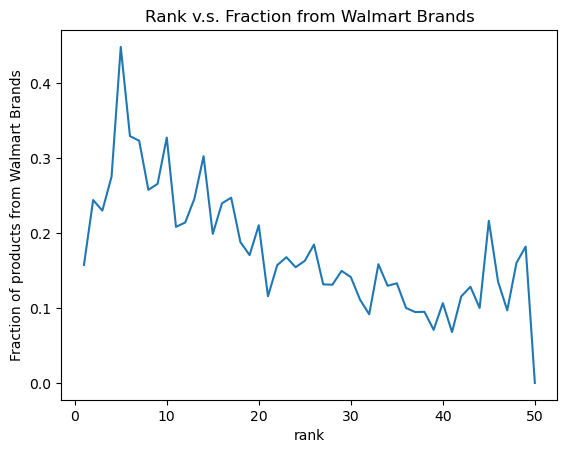

In [5]:
# Probability of being an *amazon* brand product as a function of rank:
plot1 = products_df.groupby('rank').mean(numeric_only=True)['is_walmart_brand'].plot(ylabel='Fraction of products from Walmart Brands')
plot1.set_title('Rank v.s. Fraction from Walmart Brands')

Text(0.5, 1.0, 'Rank v.s. Mean Rating')

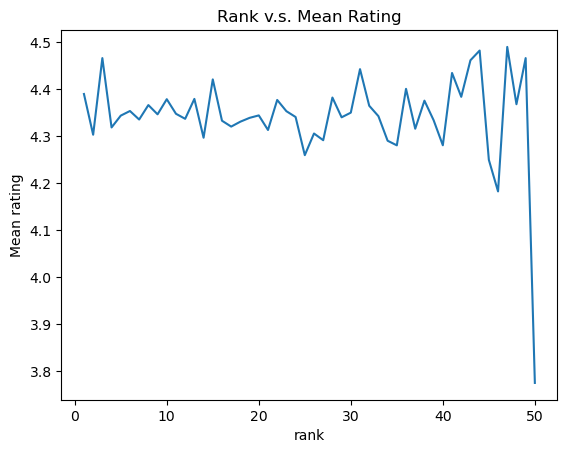

In [6]:
plot2 = products_df.groupby('rank').mean(numeric_only=True)['stars'].plot(ylabel='Mean rating')
plot2.set_title('Rank v.s. Mean Rating')

Text(0.5, 1.0, 'Rank v.s. Mean Number of Reviews')

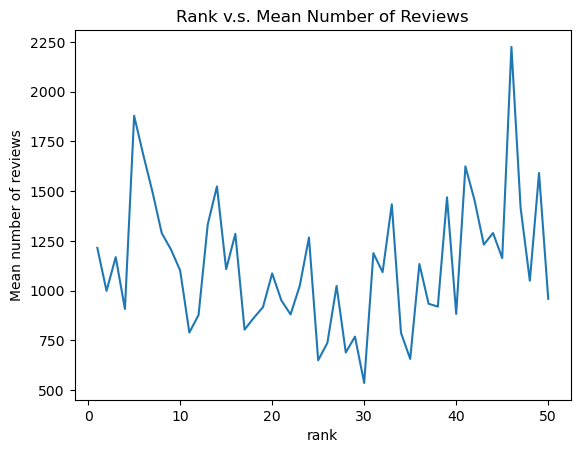

In [7]:
plot3 = products_df.groupby('rank').mean(numeric_only=True)['reviews'].plot(ylabel='Mean number of reviews')
plot3.set_title('Rank v.s. Mean Number of Reviews')

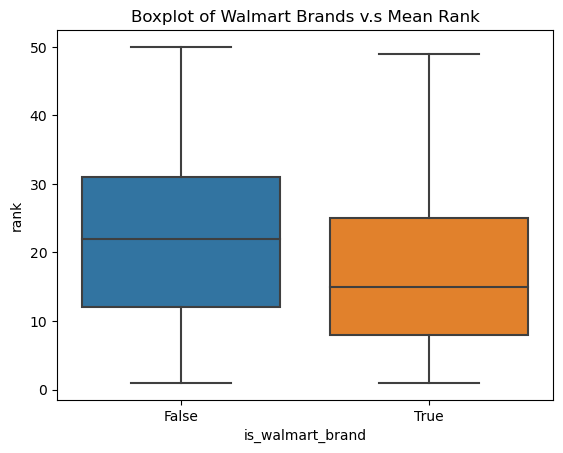

In [8]:
fig1 = sns.boxplot(products_df, x='is_walmart_brand', y='rank').set_title('Boxplot of Walmart Brands v.s Mean Rank')

In [9]:
# fig2 = sns.catplot(products_df, x='is_walmart_brand', y='rank')
# fig2.fig.suptitle('Catplot of Walmart-Brand v.s Rank', y=1.03)

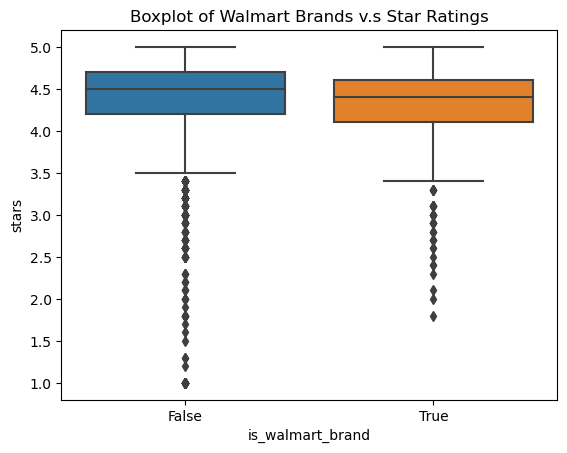

In [10]:
fig3 = sns.boxplot(products_df, x='is_walmart_brand', y='stars').set_title('Boxplot of Walmart Brands v.s Star Ratings')

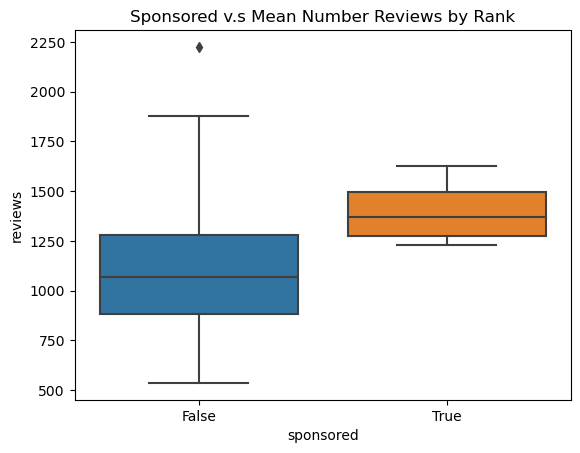

In [11]:
mean_reviews = products_df.groupby('rank').mean(numeric_only=True)['reviews']
fig4 = sns.boxplot(products_df, x='sponsored', y=mean_reviews).set_title('Sponsored v.s Mean Number Reviews by Rank')

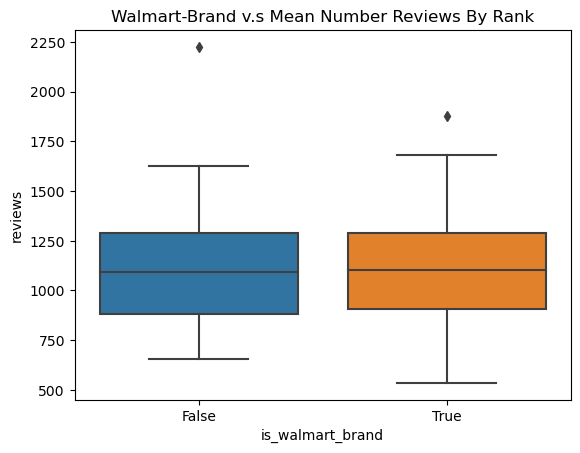

In [12]:
mean_reviews = products_df.groupby('rank').mean(numeric_only=True)['reviews']
fig5 = sns.boxplot(products_df, x='is_walmart_brand', y=mean_reviews).set_title('Walmart-Brand v.s Mean Number Reviews By Rank')

# Prep for logistic regression (ML part)

In [13]:
top_df = products_df[products_df['rank'].isin([1, 2])]

In [14]:
top_df = top_df.iloc[:-1] # Dropping last row since we are grouping in pairs

In [15]:
top_df

,Unnamed: 0,name,price,stars,reviews,sponsored,rank,is_walmart_brand
0,0,"Fresh Envy Apples, Each",$1.48,3.3,452.0,True,1,True
1,1,"Fresh Gala Apples, 3 lb Bag",$3.46,NaN,NaN,False,2,True
41,41,"Silk Dairy Free, Gluten Free, Dark Chocolate A...",$2.98,4.5,997.0,True,1,False
42,42,"Silk Dairy Free, Gluten Free, Unsweet Almond M...",$2.98,4.2,1154.0,True,2,False
81,89,"WHOLLY Avocado Minis, Chunky, Kosher, Gluten F...",$5.43,4.3,652.0,True,1,False
...,...,...,...,...,...,...,...,...
6422,8023,"Vigo Yellow Rice, 10 oz Bag",$1.44,4.4,85.0,False,2,False
6460,8062,"Fresh Organic Zucchini Squash, 2 Count",$2.96,NaN,NaN,False,2,True
6497,8100,Ziploc® Brand Freezer Bags with New Stay Open ...,$10.82,4.3,2792.0,True,1,False
6498,8101,Ziploc Brand Sandwich Bags with Grip 'n Seal T...,$11.34,4.1,1631.0,True,2,False


In [16]:
import random

# create a list for holding our product pairs
pairs = []

# we go from the beginning to the end of the top_df data frame but only every second row
for index in range(0, len(top_df), 2):

    # coin flip - who gets to be product A, who gets to be product B?
    if random.random() < 0.5:
        # accessing a row by numerical index with .iloc
        row = top_df.iloc[index]
        comparison = top_df.iloc[index+1]
    else:
        row = top_df.iloc[index+1]
        comparison = top_df.iloc[index]

    # create the pair as a dictionary
    pair = {}

    # is the product A placed higher (as in on top instead of as the second?)
    pair['is_placed_higher'] = (row['rank'] == 1)

    # now, for each variable let's calculate the delta
    for k in ['sponsored', 'stars', 'reviews', 'is_walmart_brand']:
        pair[f'{k}_delta'] = float(row[k]) - float(comparison[k])
    pairs.append(pair)

In [17]:
pairs_dataset = pd.DataFrame(pairs)
pairs_dataset.dropna(inplace=True)

In [18]:
pairs_dataset

,is_placed_higher,sponsored_delta,stars_delta,reviews_delta,is_walmart_brand_delta
1,False,0.0,-0.3,157.0,0.0
2,False,0.0,0.1,-647.0,0.0
3,False,0.0,-0.1,-2126.0,0.0
4,True,0.0,1.3,2769.0,0.0
5,True,0.0,-0.1,4736.0,0.0
...,...,...,...,...,...
155,True,0.0,0.2,-925.0,0.0
156,True,0.0,-0.1,16.0,1.0
157,True,0.0,0.1,-84.0,0.0
158,True,0.0,0.2,-10.0,0.0


In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pairs_dataset, 
                               test_size=0.2, 
                               stratify=pairs_dataset['is_placed_higher'])

In [20]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# adding the intercept as a variable
train = add_constant(train)

# selecting which features to train on
features = ['const', 'is_walmart_brand_delta']

# training a logistic regression model. First the dependent (outcome variable), then the features
log_reg = sm.Logit(train['is_placed_higher'], train[features]).fit()

Optimization terminated successfully.
         Current function value: 0.687597
         Iterations 4


In [21]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_placed_higher   No. Observations:                   76
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:               2.086e-12
Time:                        22:32:24   Log-Likelihood:                -52.257
converged:                       True   LL-Null:                       -52.257
Covariance Type:            nonrobust   LLR p-value:                     1.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2113      0.231      0.916      0.360      -0.241       0.663
is_walmart_brand_delta          0      0.821          0      1.000      -1.609       1.609
==========================================================================================
"""

In [26]:
features = ['const', 'sponsored_delta', 'stars_delta', 'reviews_delta', 'is_walmart_brand_delta']
log_reg = sm.Logit(train['is_placed_higher'], train[features]).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.675792
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_placed_higher   No. Observations:                   76
Model:                          Logit   Df Residuals:                       71
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                 0.01717
Time:                        22:33:25   Log-Likelihood:                -51.360
converged:                       True   LL-Null:                       -52.257
Covariance Type:            nonrobust   LLR p-value:                    0.7735
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1885      0.236      0.799      0.424      -0.274       0.651
sponsored_delta           -0.0420      0.661     -0.064      0.949      -1.337       1.253
stars_delta                0.4369      0.378      1.156      0.248      -0.304       1.177
reviews_delta           3.332e-05   7.38e-05      0.451      0.652      -0.000       0.000
is_walmart_brand_delta     0.1637      0.968      0.169      0.866      -1.733       2.060
==========================================================================================
"""

In [33]:
# This chunk of code is what we'll use for our analysis. You can change the values of each thing to make a "fake" product that compares to another product to see the probability of it being displayed higher on the page.

numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 0\
                   + log_reg.params['stars_delta'] * 0\
                   + log_reg.params['reviews_delta'] * 0\
                   + log_reg.params['is_walmart_brand_delta'] * 0)

print(numerator/(1+numerator))

0.5469738558056259


In [28]:
# Example 1

numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 1\
                   + log_reg.params['stars_delta'] * 3\
                   + log_reg.params['reviews_delta'] * 0\
                   + log_reg.params['is_walmart_brand_delta'] * 0) 

print(numerator/(1+numerator))

# This means if product A is a sponsored product and has been rated as 3 stars, while product B is not sponsored and has 0 stars, there is around a 97% chance that product A will be displayed before product B on the search page.

0.8110819874346461


In [29]:
# Example 2

numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 0\
                   + log_reg.params['stars_delta'] * 4\
                   + log_reg.params['reviews_delta'] * (-6000) # note the negative sign so it affects product B
                   + log_reg.params['is_walmart_brand_delta'] * 0) 

print(numerator/(1+numerator))

# This means if product A has been rated as 4 stars, while product B has 0 stars but 6000 reviews, there is around a 98% chance that product A will be displayed before product B on the search page.

0.8501813803234847


In [30]:
# Example 3
numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 1\
                   + log_reg.params['stars_delta'] * 5\
                   + log_reg.params['reviews_delta'] * 1000\
                   + log_reg.params['is_walmart_brand_delta'] * 1)
                   
print(numerator/(1+numerator))

# This means if product A is a sponsored product, has the maximum rating of 5 stars, a high number of 1000 reviews, and is a Walmart brand, while product B is not sponsored, has a lower star rating, fewer reviews, and is not a Walmart brand, there is a 92.6% probability that product A will be displayed before product B on the search page.

0.9260684026029131


In [34]:
# Example 4
numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 0\
                   + log_reg.params['stars_delta'] * 2\
                   + log_reg.params['reviews_delta'] * (-100)\
                   + log_reg.params['is_walmart_brand_delta'] * 1)
                   
print(numerator/(1+numerator))

# This means if product A is not sponsored, has a moderate rating of 2 stars, fewer reviews, and is a Walmart brand, while product B is sponsored, has a higher star rating, more reviews, and is not a Walmart brand, there is a 77.25% probability that product A will be displayed before product B on the search page.

0.7725119805270205


In [35]:
# Example 5
numerator = np.e**(log_reg.params['const']\
                   + log_reg.params['sponsored_delta'] * 1\
                   + log_reg.params['stars_delta'] * 4\
                   + log_reg.params['reviews_delta'] * (-500)\
                   + log_reg.params['is_walmart_brand_delta'] * 0)
                   
print(numerator/(1+numerator))

# This means if product A is a sponsored product, has a high rating of 4 stars, a moderate number of 500 reviews, and is not a Walmart brand, while product B is not sponsored, has a lower star rating, fewer reviews, and is also not a Walmart brand, there is a 86.7% probability that product A will be displayed before product B on the search page.

0.8672972642802487
